# 시계열 분석

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split
from xgboost import XGBRFRegressor, XGBRegressor

In [2]:
df_raw = pd.read_pickle("/home/pirl/Downloads/merge_F_검색량추가190804_SW.pkl")

In [3]:
df_raw["Calendar Day일 2"] = pd.to_datetime(df_raw["Calendar Day일 2"])

In [4]:
df_raw = df_raw[df_raw["Calendar Day일 2"] > '2019-01-01']

In [5]:
df_raw["yearmoth"] =df_raw["Calendar Day일 2"].astype(str).str[:7]

In [6]:
df = df_raw.groupby(["CUSTOMER NAME","KF규격","지역","구군","Calendar Day일 2"]).mean()
df[['금액','Sales (Bag)','Sales SU','박스입수','수량(CS)','UPC']] =df_raw.groupby(["CUSTOMER NAME","KF규격","지역","구군","Calendar Day일 2"])[['금액','Sales (Bag)','Sales SU','박스입수','수량(CS)','UPC']].sum()

df.head()

UPC  Sales (Bag)  \
CUSTOMER NAME KF규격 지역 구군  Calendar Day일 2                              
(주)지에스리테일 본부  0    경기 과천시 2019-01-10       8.800000e+12            9   
                      광명시 2019-02-14       8.800000e+12            5   
                          2019-02-15       8.800000e+12            5   
                      광주시 2019-02-15       1.760000e+13           10   
                          2019-02-19       7.920000e+13           30   

                                           Sales SU  박스입수  수량(CS)     금액  \
CUSTOMER NAME KF규격 지역 구군  Calendar Day일 2                                  
(주)지에스리테일 본부  0    경기 과천시 2019-01-10            0.0    50     0.2  27000   
                      광명시 2019-02-14            3.0    50     0.1  15000   
                          2019-02-15            0.0    50     0.1  10000   
                      광주시 2019-02-15            0.0   100     0.2  30000   
                          2019-02-19            1.0   376     0.6  87675   

                                                    가격        인구  \
CUSTOMER NAME KF규격 지역 구군  Calendar Day일 2                          
(주)지에스리테일 본부  0    경기 과천시 2019-01-10       3000.000000   58195.0   
                      광명시 2019-02-14       3000.000000  325766.0   
                          2019-02-15       2000.000000  325766.0   
                      광주시 2019-02-15       3000.000000  364472.0   
                          2019-02-19       3190.333333  364472.0   

                                           선행종합지수(2015=100)  동행종합지수(2015=100)  \
CUSTOMER NAME KF규격 지역 구군  Calendar Day일 2                                       
(주)지에스리테일 본부  0    경기 과천시 2019-01-10                  113.5             110.0   
                      광명시 2019-02-14                  113.6             109.7   
                          2019-02-15                  113.6             109.7   
                      광주시 2019-02-15                  113.6             109.7   
                          2019-02-19                  113.6             109.7   

                                           ...  일사(MJ/m2)    적설(cm)  \
CUSTOMER NAME KF규격 지역 구군  Calendar Day일 2  ...                        
(주)지에스리테일 본부  0    경기 과천시 2019-01-10       ...   0.438182  0.000000   
                      광명시 2019-02-14       ...   1.137500  0.000000   
                          2019-02-15       ...   0.287500  2.378723   
                      광주시 2019-02-15       ...   0.287500  2.378723   
                          2019-02-19       ...   0.347500  1.732394   

                                           3시간신적설(cm)  전운량(10분위)  중하층운량(10분위)  \
CUSTOMER NAME KF규격 지역 구군  Calendar Day일 2                                       
(주)지에스리테일 본부  0    경기 과천시 2019-01-10            0.000   6.583333     4.733333   
                      광명시 2019-02-14            0.000   6.350000     2.241667   
                          2019-02-15            0.625   8.858333     6.025000   
                      광주시 2019-02-15            0.625   8.858333     6.025000   
                          2019-02-19            0.975   8.791667     5.858333   

                                           최저운고(100m )      시정(10m)  지면온도(°C)  \
CUSTOMER NAME KF규격 지역 구군  Calendar Day일 2                                       
(주)지에스리테일 본부  0    경기 과천시 2019-01-10         22.418605  1310.233333 -1.360833   
                      광명시 2019-02-14         59.119048  1672.947917 -0.165000   
                          2019-02-15         10.977778   900.468750 -0.255833   
                      광주시 2019-02-15         10.977778   900.468750 -0.255833   
                          2019-02-19          7.370787   435.854167 -0.127500   

                                           미세검색량  초미세검색량  
CUSTOMER NAME KF규격 지역 구군  Calendar Day일 2                 
(주)지에스리테일 본부  0    경기 과천시 2019-01-10         4.0     4.0  
                      광명시 2019-02-14        17.0    26.0  
                          2019-02-15        17.0    26.0  
                      광주시 2019-02-15    

In [7]:
df_raw['Sales (Bag)'].sum()

209756

In [8]:
df_true = df.reset_index()
pd.DataFrame(list(df_true.columns)).to_excel("/home/pirl/Downloads/test.xlsx")

In [9]:
df_0 = df_true

In [10]:
df_0.drop(['금액','Sales SU','수량(CS)','UPC','day',"Calendar Day일 2","박스입수"], axis=1, inplace=True)

In [11]:
df_0.corr()

,Sales (Bag),가격,인구,선행종합지수(2015=100),동행종합지수(2015=100),후행종합지수(2015=100),gdp,연령,평균소득,SO2,...,일사(MJ/m2),적설(cm),3시간신적설(cm),전운량(10분위),중하층운량(10분위),최저운고(100m ),시정(10m),지면온도(°C),미세검색량,초미세검색량
Sales (Bag),1.000000,-0.038028,0.036176,-0.017526,0.146940,-0.070923,-0.000185,-0.096492,-0.001406,0.058456,...,-0.058364,-0.077261,-0.051222,0.008448,0.008048,-0.049832,-0.201735,0.056903,0.211502,0.203610
가격,-0.038028,1.000000,0.034847,-0.000563,0.002319,-0.001295,0.000059,-0.016594,0.029793,-0.011327,...,0.017022,0.007742,-0.006011,-0.007372,-0.001998,0.006126,0.012662,0.000651,0.008209,0.006870
인구,0.036176,0.034847,1.000000,0.035811,-0.016759,0.028823,-0.000177,-0.431464,0.063642,0.014482,...,0.077163,0.008479,0.017196,-0.052285,-0.035160,-0.027362,-0.007901,0.058192,-0.004218,0.000101
선행종합지수(2015=100),-0.017526,-0.000563,0.035811,1.000000,-0.908396,0.985232,0.000014,-0.002458,0.039685,-0.010226,...,0.201214,0.219301,0.155688,0.267634,0.163166,0.075626,-0.154523,0.549047,-0.055371,-0.039436
동행종합지수(2015=100),0.146940,0.002319,-0.016759,-0.908396,1.000000,-0.966573,-0.000045,-0.015876,-0.023002,-0.004819,...,-0.176083,-0.258891,-0.184492,-0.304471,-0.214428,-0.016802,0.094911,-0.479860,0.122514,0.090281
후행종합지수(2015=100),-0.070923,-0.001295,0.028823,0.985232,-0.966573,1.000000,0.000027,0.004994,0.033755,-0.004297,...,0.195499,0.240502,0.171025,0.288808,0.187871,0.053256,-0.133625,0.533202,-0.084127,-0.061155
gdp,-0.000185,0.000059,-0.000177,0.000014,-0.000045,0.000027,1.000000,0.000070,-0.000043,0.000007,...,-0.000047,0.000046,0.000024,0.000035,0.000066,-0.000076,-0.000009,-0.000007,-0.000079,-0.000064
연령,-0.096492,-0.016594,-0.431464,-0.002458,-0.015876,0.004994,0.000070,1.000000,-0.209033,-0.041225,...,-0.027132,-0.012025,0.038024,0.046874,0.100716,-0.051700,-0.025718,0.173801,-0.004100,-0.003780
평균소득,-0.001406,0.029793,0.063642,0.039685,-0.023002,0.033755,-0.000043,-0.209033,1.000000,0.012576,...,0.016565,-0.037506,-0.040088,-0.049530,-0.009411,-0.013313,0.031533,0.063857,-0.019751,-0.016683
SO2,0.058456,-0.011327,0.014482,-0.010226,-0.004819,-0.004297,0.000007,-0.041225,0.012576,1.000000,...,0.052220,0.193658,0.189610,-0.013042,0.009544,-0.055337,0.141665,-0.153355,0.168548,0.173763


In [12]:
df_0.columns

Index(['CUSTOMER NAME', 'KF규격', '지역', '구군', 'Sales (Bag)', '가격', '인구',
       '선행종합지수(2015=100)', '동행종합지수(2015=100)', '후행종합지수(2015=100)', 'gdp', '연령',
       '평균소득', 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25', 'month', '기온(°C)',
       '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)',
       '현지기압(hPa)', '해면기압(hPa)', '일조(hr)', '일사(MJ/m2)', '적설(cm)', '3시간신적설(cm)',
       '전운량(10분위)', '중하층운량(10분위)', '최저운고(100m )', '시정(10m)', '지면온도(°C)',
       '미세검색량', '초미세검색량'],
      dtype='object')

In [13]:
df_0.dropna(inplace=True)
df_0.month = df_0.month.astype(str)
df_0 = pd.get_dummies(df_0)
df_0.head()


,Sales (Bag),가격,인구,선행종합지수(2015=100),동행종합지수(2015=100),후행종합지수(2015=100),gdp,연령,평균소득,SO2,...,구군_처인구,구군_파주시,구군_팔달구,구군_평택시,구군_포천시,구군_하남시,구군_화성시,month_1.0,month_2.0,month_3.0
0,9,3000.000000,58195.0,113.5,110.0,112.5,402678.4,41.6,1475779.0,0.004426,...,0,0,0,0,0,0,0,1,0,0
1,5,3000.000000,325766.0,113.6,109.7,112.8,402678.4,40.9,1308638.0,0.005937,...,0,0,0,0,0,0,0,0,1,0
2,5,2000.000000,325766.0,113.6,109.7,112.8,402678.4,40.9,1308638.0,0.006279,...,0,0,0,0,0,0,0,0,1,0
3,10,3000.000000,364472.0,113.6,109.7,112.8,402678.4,40.6,1346374.0,0.006279,...,0,0,0,0,0,0,0,0,1,0
4,30,3190.333333,364472.0,113.6,109.7,112.8,402678.4,40.6,1346374.0,0.005346,...,0,0,0,0,0,0,0,0,1,0


In [14]:
#종속변수, 독립변수 분할
df_raw_y = df_0['Sales (Bag)']
df_raw_x = df_0.drop(['Sales (Bag)'],axis=1,inplace=False)
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,df_raw_y, test_size=0.3,random_state=1234)

In [15]:
tree_uncustumized = RandomForestRegressor(random_state=1234)
tree_uncustumized.fit(df_train_x,df_train_y)

print(tree_uncustumized.score(df_train_x,df_train_y))

print(tree_uncustumized.score(df_test_x,df_test_y))

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8800117899130493
0.7255003917310746


In [16]:
train_score = []
validation_score = []

para_n_tree = [n_tree*10 for n_tree in range(1,5)]

for v_n_estimator in para_n_tree :
    rf =RandomForestRegressor(random_state=1234,n_estimators=v_n_estimator)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    validation_score.append(rf.score(df_test_x,df_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] =para_n_tree
df_score_n["TrainScore"] =train_score
df_score_n["ValidationScore"] =validation_score
df_score_n.round(3)

,n_estimators,TrainScore,ValidationScore
0,10,0.880,0.726
1,20,0.906,0.706
2,30,0.919,0.706
3,40,0.925,0.693


In [18]:
train_score = []
val_score = []

para_n_leaf = [n_leaf*1 for n_leaf in range(1,10)]

for v_min_samples_leaf in para_n_leaf :
    rf = RandomForestRegressor(random_state=1234, n_estimators=11, min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    val_score.append(rf.score(df_test_x,df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSampleLeaf"] =para_n_leaf
df_score_leaf["TrainScore"] =train_score
df_score_leaf["ValidationScore"] =val_score
df_score_leaf.round(3)

,MinSampleLeaf,TrainScore,ValidationScore
0,1,0.876,0.729
1,2,0.825,0.647
2,3,0.754,0.638
3,4,0.705,0.583
4,5,0.667,0.565
5,6,0.653,0.556
6,7,0.617,0.539
7,8,0.599,0.527
8,9,0.578,0.511


In [19]:
train_score = []
test_score = []

para_split = [n_split*2 for n_split in range(1,18)]

for v_min_samples_split in para_split :
    rf = RandomForestRegressor(random_state=1234, n_estimators=11,min_samples_leaf=1, min_samples_split=v_min_samples_split)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSampleSplit"] =para_split
df_score_split["TrainScore"] =train_score
df_score_split["ValidationScore"] =test_score
df_score_split.round(3)

,MinSampleSplit,TrainScore,ValidationScore
0,2,0.876,0.729
1,4,0.842,0.700
2,6,0.815,0.696
3,8,0.784,0.693
4,10,0.770,0.686
5,12,0.753,0.689
6,14,0.741,0.679
7,16,0.729,0.680
8,18,0.714,0.666
9,20,0.693,0.650


In [20]:
train_score = []
test_score = []

para_depth = [depth for depth in range(25,35)]

for v_max_depth in para_depth :
    rf = RandomForestRegressor(random_state=1234, n_estimators=11,min_samples_leaf=1,min_samples_split=2, max_depth=v_max_depth)
    rf.fit(df_train_x,df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["MaxDepth"] =para_depth
df_score_depth["TrainScore"] =train_score
df_score_depth["ValidationScore"] =test_score
df_score_depth.round(3)

,MaxDepth,TrainScore,ValidationScore
0,25,0.875,0.712
1,26,0.881,0.705
2,27,0.874,0.706
3,28,0.873,0.714
4,29,0.873,0.716
5,30,0.876,0.729
6,31,0.876,0.729
7,32,0.876,0.729
8,33,0.876,0.729
9,34,0.876,0.729


In [21]:
train_score=[]
test_score=[]

gf_final =RandomForestRegressor(random_state=1234, n_estimators=11,min_samples_leaf=1,min_samples_split=2, max_depth=30)
gf_final.fit(df_train_x,df_train_y)
train_score.append(gf_final.score(df_train_x,df_train_y))

test_score.append(gf_final.score(df_test_x,df_test_y))
print("Score on training set :" ,(gf_final.score(df_train_x,df_train_y)).round(3))

print("Score on test set :" ,(gf_final.score(df_test_x,df_test_y)).round(3))

Score on training set : 0.876
Score on test set : 0.729


# 모델 저장

In [22]:
import pickle
# save the model to disk
filename = '/home/pirl/Downloads/finalized_model.sav'
pickle.dump(gf_final, open(filename, 'wb'))

In [23]:
import joblib

In [24]:
import joblib
model = joblib.load('/home/pirl/Downloads/finalized_model.sav')

In [25]:
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=None,
           oob_score=False, random_state=1234, verbose=0, warm_start=False)

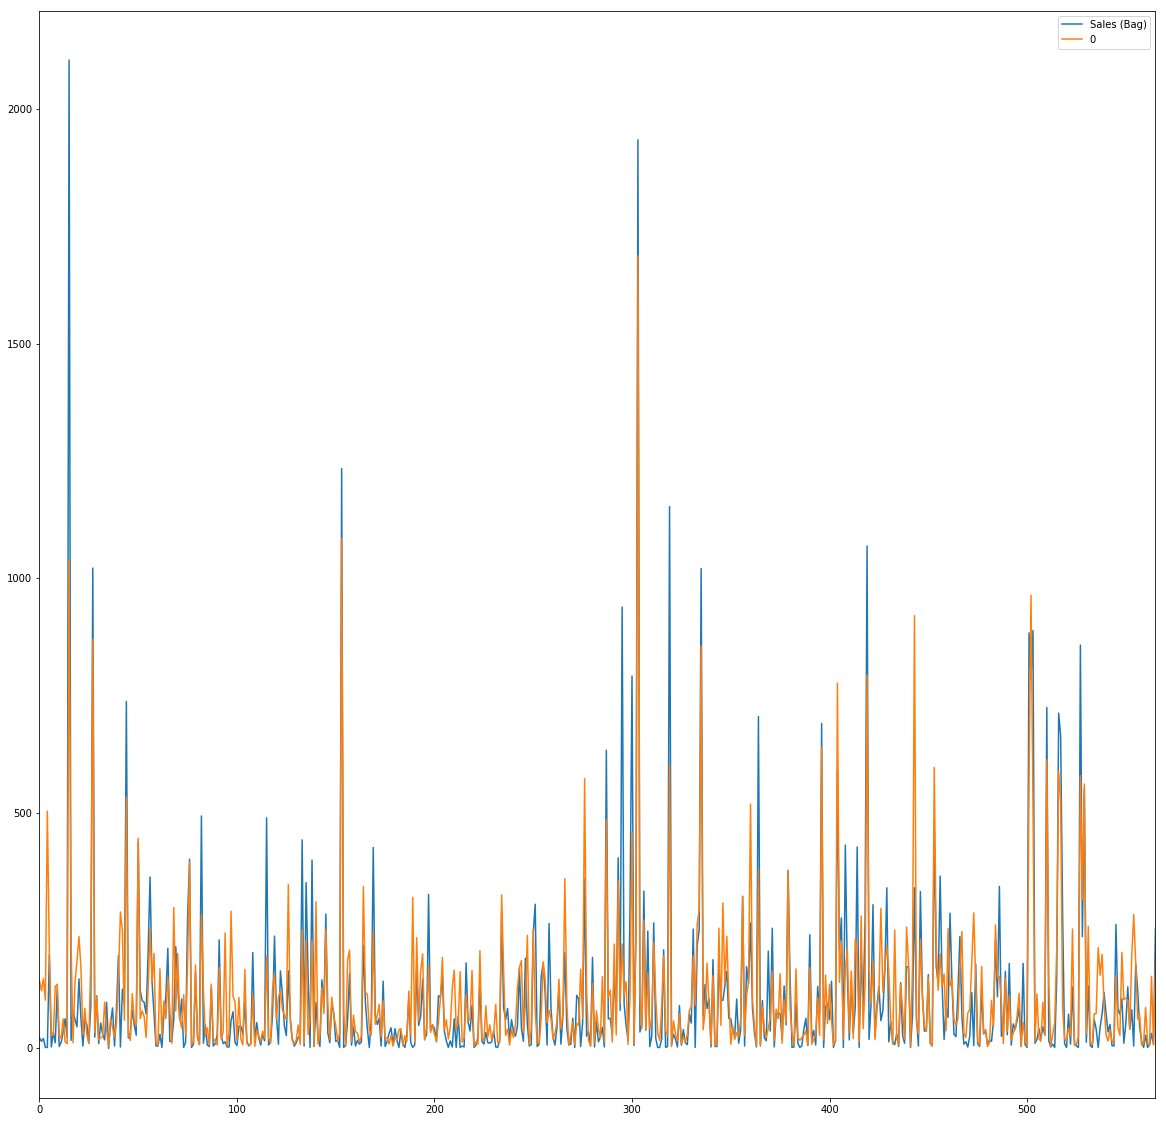

In [26]:
pd.DataFrame(gf_final.predict(df_test_x),df_test_y).reset_index().plot(figsize=(20,20))

In [27]:
pd.DataFrame(gf_final.predict(df_test_x),df_test_y).reset_index()

,Sales (Bag),0
0,22,142.727273
1,14,121.818182
2,20,147.454545
3,1,101.909091
4,1,504.272727
5,199,204.545455
6,2,26.454545
7,33,27.000000
8,11,130.818182
9,127,135.363636


In [28]:
import matplotlib.font_manager as fm
font_location = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname = font_location).get_name()
matplotlib.rc('font',family= font_name)
import warnings
warnings.filterwarnings('ignore')

In [29]:
df_importance = pd.DataFrame()
df_importance["Feature"] = df_train_x.columns
df_importance["Importance"] = gf_final.feature_importances_

df_importance.sort_values("Importance",ascending=False,inplace=True)
df_importance.round(3)

,Feature,Importance
62,구군_권선구,0.078
35,CUSTOMER NAME_㈜신세계 이마트부문,0.072
0,가격,0.058
12,PM10,0.048
16,풍속(m/s),0.040
13,PM25,0.037
10,O3,0.036
37,CUSTOMER NAME_롯데쇼핑㈜ 롯데마트,0.035
6,연령,0.035
40,CUSTOMER NAME_홈플러스테스코(주),0.035


In [30]:
df_importance = df_importance[df_importance['Importance']>0.01]

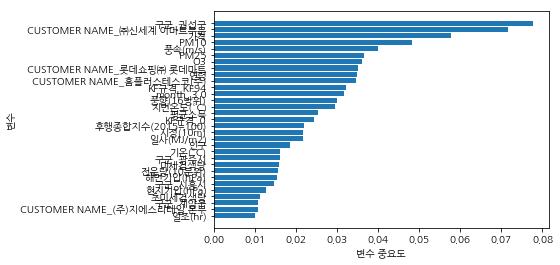

In [31]:
df_importance.sort_values("Importance",ascending=True,inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates,df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")
plt.show()